# An Interactive Guide to Spike Sorting

*By Eric Osband*

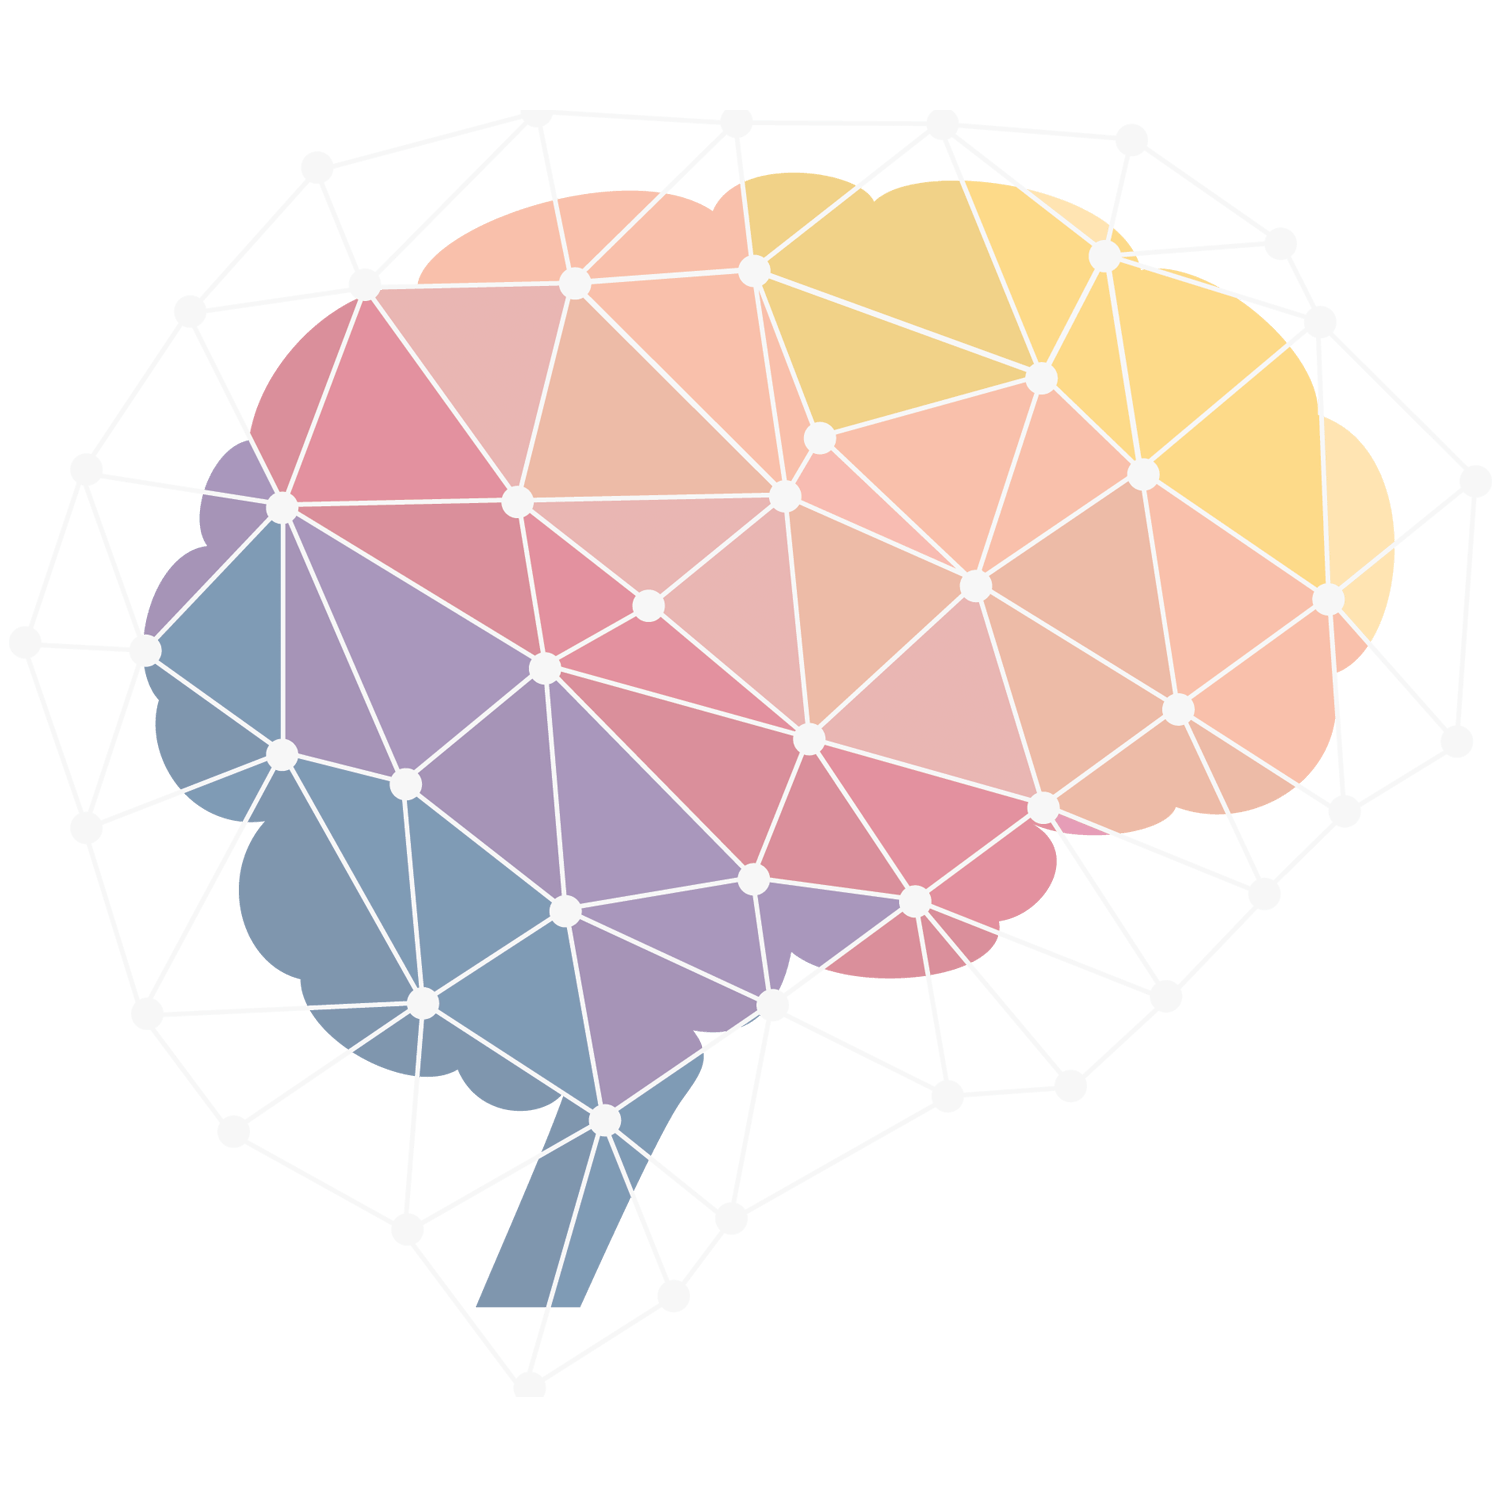

## Table of contents
<font size = "+1.5"><ul style="list-style-type:upper-roman;">
    <li>[Introduction](#intro)</li>
    <li>[Import statements](#import)</li>
    <li>[Inputting data](#input)</li>
    <li>[Visualization](#visualization)</li>
    <li>[Raw data](#raw)</li>
    <li>[Filtering](#filtering)</li>
    <li>[Spike Detection](#detection)</li>
    <li>[Dimensionality Reduction](#reduction)</li>
    <li>[Clustering](#clustering)</li>
    <li>[Conclusion and Issues](#conclusion)</li>
</ul></font>

## Introduction <a id = "intro">

In the escapade of trying to understand and model the brain in computational neuroscience, one crucial element that often gets overlooked is the bridge between the biology and the computation. There are many biologists and brain surgeons who work on placing electrodes and receptors into the brain safely, and then there are many mathematicians and analysists who use the vast amounts of data collected by research teams to create models and neural networks than can then be used to stimulate certain parts of the brain themselves. But the bridge between these two is crucial and often overlooked. How can we actually get the spikes in a nice, mathematical function format? We can't take out a single neuron and see when it pulses, but instead have to put in pieces of metal directly to the brain, have them listen to a bunch of information, and somehow make it out into a few groups of distinct neurons. In this analysis, we will take a sample recording dataset and attempt to isolate the distinct spikes. 

## Import statements <a id = "import">

In [1]:
# standard import statements.
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from itertools import combinations
from sklearn import datasets
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import struct
from scipy.signal import butter, lfilter, filtfilt
import warnings
import random
# UNCOMMENT WHEN TURNING THIS IN
# warnings.filterwarnings("ignore")

%matplotlib inline

plt.style.use("bmh")

## Inputting data <a id ="input">

In [2]:
# from http://www.spikesortingtest.com/python_code/

def read_file(fname):
    with open(fname,'rb') as fin:
        header = fin.read(16)                                   #Header info; not used
        iformat = struct.unpack('i',fin.read(4))[0]             #Default: '1002'
        SampleFrequency = struct.unpack('i',fin.read(4))[0]     #Sample frequency
        n_electrodes = struct.unpack('i',fin.read(4))[0]        #No. of electrodes
        n_vd_samples = struct.unpack('i',fin.read(4))[0]        #No. of samples
        vscale_HP = struct.unpack('f',fin.read(4))[0]           #Scaling of int2 values below to save space, currently 0.1

        Siteloc1 = np.zeros((2*n_electrodes), dtype=np.int16)
        Readloc = np.zeros((n_electrodes), dtype=np.int32)
        for i in range(n_electrodes):
            Siteloc1[i*2] = struct.unpack('h', fin.read(2))[0]
            Siteloc1[i*2+1] = struct.unpack('h', fin.read(2))[0]
            Readloc[i] = struct.unpack('i', fin.read(4))[0]

        ec_traces =  np.fromfile(fin, dtype=np.int16, count=n_electrodes*n_vd_samples)
        ec_traces.shape = n_electrodes, n_vd_samples
        
        print("Header: " + str(header))
        print("Sample frequency: " + str(SampleFrequency))
        print("Number of electrodes: " + str(n_electrodes))
        return ec_traces


Initially I had huge trouble trying to convert the data to a usable format. The [spikesorting dataset source](http://www.spikesortingtest.com/datasets/) had a huge number of datasets but very little information about what to do with them. They offered a .dat file and a .tsf file, and I had never heard of either. I could not convert it to a traditional txt array, and so figured it was an int array, but since the description of the dataset told me that there were 15 channels, I did not know how to split the data. Was every 15th entry the next time sample of the specific node, or was it all the data from one, then all of it from the next, etc.? Were some of the datapoints time stamps? 

I then read more into the website and it said that users should contact them about loading in the dataset, but when I tried I got a "server error: 500". Combined with the old-fashioned look of the site, I believe that the server simply is no longer running, so I have to take some risks in fashioning the dataset to my liking. Note that the largest part of this is simply trimming the dataset, since trying to perform operations on the whole dataset simply crashes the kernel. 

However, I finally looked a little longer and the site actually had sample code for importing the .tsf file! So I switched to that below, and it makes it so much easier.

In [3]:
dt = read_file("silico_1.tsf")
print(dt[0:10])
print(dt.shape)

Header: b'Test spike file '
Sample frequency: 20000
Number of electrodes: 15
[[  0   0   0 ...  16  -7 -12]
 [  0   0   0 ...  13 -11 -16]
 [  0   0   0 ...  38  24  21]
 ...
 [  0   1   2 ... 237 243 250]
 [  0   1   2 ... 264 271 279]
 [  1   1   2 ... 283 289 296]]
(15, 4800000)


In [4]:
channel = 12 # for consistency purposes we dictate this channel to be the one we use.
data = dt[channel] 
print("Randomly chosen channel: " + str(channel))

Randomly chosen channel: 12


The data comes in the form of 15 channels of 4,800,000 samples. Since we do not have extreme processing power, nor are we experienced enough to take on a huge amount of data, we are randomly choosing a channel to work with.

## Visualization <a id = "visualization">

First we want to just see what the data looks like.

In [5]:
# A simple plotting function to visualize certain sections of the data
def plot_range(minI,maxI, plot = plt):
    x = np.arange(minI,maxI)
    new_data = data[minI:maxI]
    plot.plot(x, new_data) # the c=_ part specifies the color of the datapoints

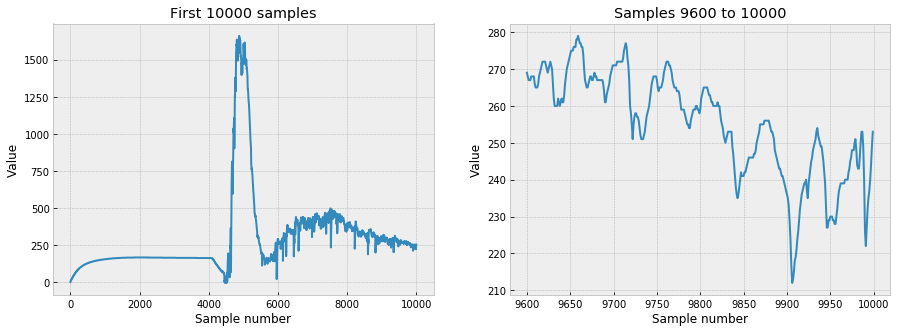

In [6]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
plot_range(0,10000, ax1)
plot_range(9600,10000, ax2)
ax1.set_xlabel("Sample number")
ax2.set_xlabel("Sample number")
ax1.set_ylabel("Value")
ax2.set_ylabel("Value")
ax1.set_title("First 10000 samples")
ax2.set_title("Samples 9600 to 10000")
plt.show()

Here is the basic view of the first 10000 entries in the dataset. To be honest I am not completely sure what is going on here, but what I do seem to understand is that for the first 5000 samples, not much seems to be going on, so I will simply cut those out. This dataset after that however seems to be very continuous, which is good and in the format that we would like.

## Raw data <a id="raw">

In [7]:
raw_data = data[20000:60000] # arbitrarily choosing these 20,000 entries
indices = np.array(range(0,len(raw_data)))

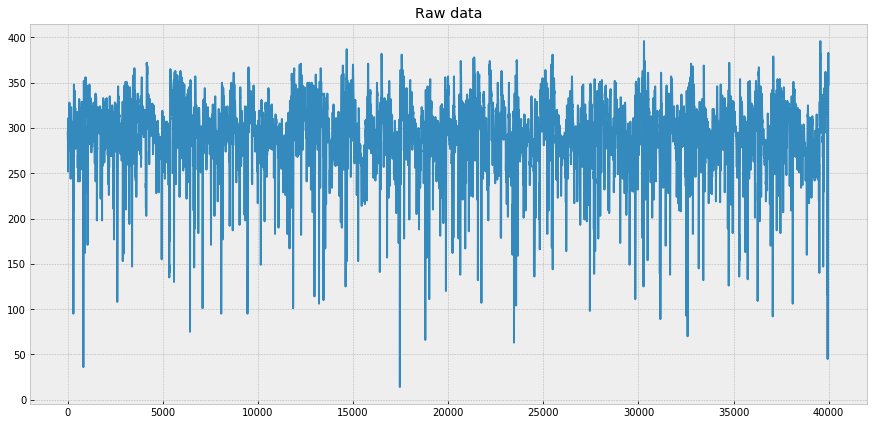

In [8]:
plt.figure(figsize=(15,7))
plt.plot(raw_data)
plt.title("Raw data")
plt.show()

As you can see, this part of the data looks much more like we'd expect and something we can work with. yes, it looks quite bottom-heavy, bu that is exactly what we would expect. **Assuming this data comes from just one electrode**, that represents the background noise which we will be cutting out through a band-pass filter in the next step. I am not sure why the data seems to be cluttered towards the top – since we would expect the noisy bits to be clustered towards the bottom – but I suppose this means that there is just a lot of noise overall. Also, I am unsure what it means when the data drops down suddenly and then shoots back up. I would understand it if spike values could be negative, but since they can't, this means that at certain points the electric potential suddenly dropped to near zero. Most likely these are simply places that the different spike frequencies happened to line up at a moment of no spike, but I just do not understand what information those drops would be conveying, since as we learned earlier in the term, the only information carried is whether or not a spike happens (and sometimes how often they happen).

## Filtering <a id="filtering">

We will begin by filtering our raw data to eliminate low and high frequency noise.

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


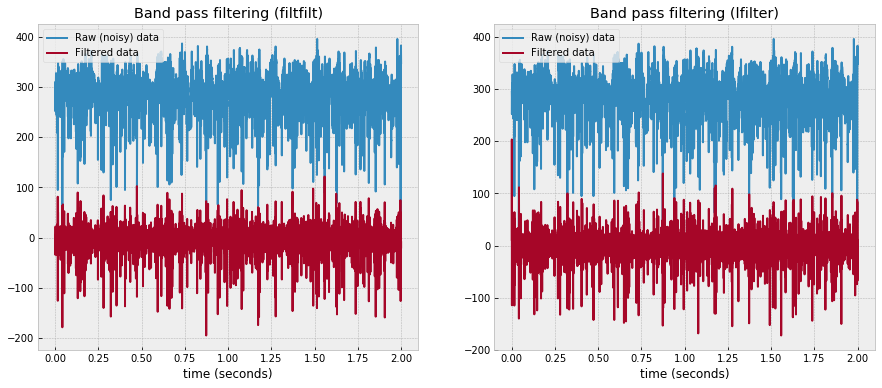

In [9]:
# The following functions and code are from https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
# in order to perform a band-pass filter from a given low and high frequency threshold.
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, np.array([low, high]), btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, ff=True):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if ff:
        y = filtfilt(b, a, data) # this is actually matlab's function filtfilt
    else:
        y = lfilter(b, a, data) # just a linear filter
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 20000.0 # we found this above
lowcut = 300.0 # These values were recommended by the scholarpedia article cited below
highcut = 3000.0

t = indices/20000 # converting indices to seconds
b, a = butter_bandpass(lowcut, highcut, fs, order=3)
 
f = plt.figure(figsize=(15,6))
ax1 = f.add_subplot(121)
filtered_data_filtfilt = butter_bandpass_filter(raw_data, lowcut, highcut, fs, order=3, ff=True)
ax1.plot(t, raw_data, label='Raw (noisy) data')
ax1.plot(t, filtered_data_filtfilt, label='Filtered data')
ax1.set_xlabel('time (seconds)')
ax1.legend(loc='upper left')
ax1.set_title("Band pass filtering (filtfilt)")

ax2 = f.add_subplot(122)
filtered_data_lfilter = butter_bandpass_filter(raw_data, lowcut, highcut, fs, order=3, ff=False)
ax2.plot(t, raw_data, label='Raw (noisy) data')
ax2.plot(t, filtered_data_lfilter, label='Filtered data')
ax2.set_xlabel('time (seconds)')
ax2.legend(loc='upper left')
ax2.set_title("Band pass filtering (lfilter)")
plt.show()


**The purpose of this step is to eliminate noise.** Electrodes record the electric potential around them, which means that they will recieve data from more than just one cell. This is both their greatest virtue and vice: they can record many cells at once, but also may take in background noise. Noise in the case of spike recording comes from either a baseline electric potential in the brain tissue or far off cells. Since we do not care about cells that rarely ever fire or extremely fast firing – cases in which cells fire at a continuous rate for the entire recording period – we eliminate the spike data that occurs below 300Hz or above 3000Hz. This is a compromise: ideally our range would be extremely narrow so we see only the exact spikes, but in that case we may miss out on other spike data. *[(source)](https://neurophysics.ucsd.edu/publications/obd_ch3_2.pdf)*

**[Matlab's filtfilt](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.filtfilt.html)** is a two-step linear filter that gets applied over the data to perform this task. A normal linear filter, which you can see on the right, is causal, meaning that the data at previous times impacts the current value of the filtered function. This would distort the shapes of our spikes when we root them out. Filtfilt applies a linear filter twice, once forwards and once backwards, to try and mitigate this and imitate noncausality.

## Spike detection <a id="detection">
    
We now have to detect the spikes and pull them out of our filtered data.

In [10]:
filtered_data = filtered_data_filtfilt

In [11]:
# from http://www.scholarpedia.org/article/Spike_sorting and others
sigma_n = np.median(abs(filtered_data)) / 0.6745
threshold = 5 * sigma_n

The above equations were stated in mutliple sources as the ideal compromise for a threshold to detect spike sorting. This threshold is defined to be about five standard deviations of the signal, and has been shown to mitigate the effect of high frequency distortion. The purpose of the median here is to eliminate the "pull" of extremely high spikes on this threshold.

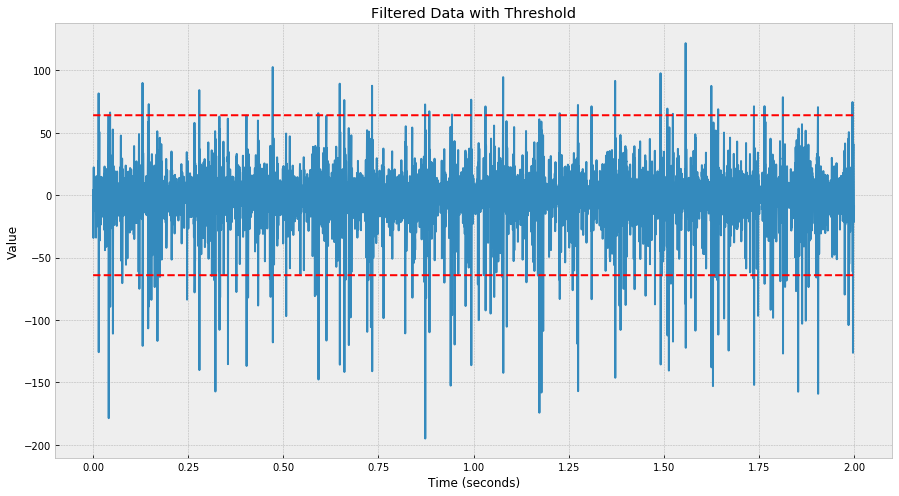

In [12]:
def filtered_dataplot():
    plt.plot(t, filtered_data)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Value")
    plt.axis("tight")
    
plt.figure(figsize=(15,8))
plt.title("Filtered Data with Threshold")
filtered_dataplot()
plt.plot(t, threshold * np.ones(len(t)), c="r", linestyle="--" )
plt.plot(t, -1*threshold * np.ones(len(t)), c="r", linestyle="--" )
plt.show()

Number of spikes: 687


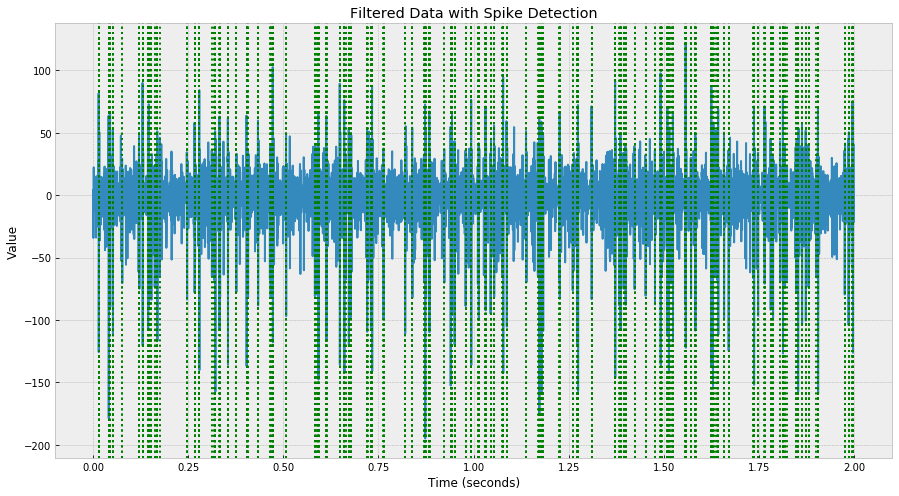

In [13]:
plt.figure(figsize=(15,8))
filtered_dataplot()
detected_spikes_indices = []
for i in range(len(filtered_data)):
    datapoint = filtered_data[i]
    if datapoint >= threshold or datapoint <= -1 * threshold:
        detected_spikes_indices.append(i)
        plt.axvline(i/20000, c="g", linestyle=":")
plt.title("Filtered Data with Spike Detection")
print("Number of spikes: " + str(len(detected_spikes_indices)))
plt.show()

As you can see above, the green dotted lines are the places in which we detected the spikes. They line up with the pointy bits as they are supposed to, but clearly some are in dense groups, while some are completely alone. We will account for this below.

In [14]:
nSamples = len(t)
nMSBetweenSamples = 1000 / len(t)
print("Number of samples per second: " + str(nSamples))
print("Number of miliseconds between samples: " + str(nMSBetweenSamples))

Number of samples per second: 40000
Number of miliseconds between samples: 0.025


In [15]:
prev = -500000
spikes = []
for i in detected_spikes_indices:
    distanceBetween = int(1 /  nMSBetweenSamples)
    if i - prev >= distanceBetween: # we want at least 1mS between the spikes we record to eliminate overlap
        newSpikeTrain = abs(filtered_data[i-distanceBetween:i+distanceBetween]) # each spike train will be 2mS long
        spikes.append(newSpikeTrain)
        prev = i
print("Number of separated spikes:" + str(len(spikes)))

Number of separated spikes:117


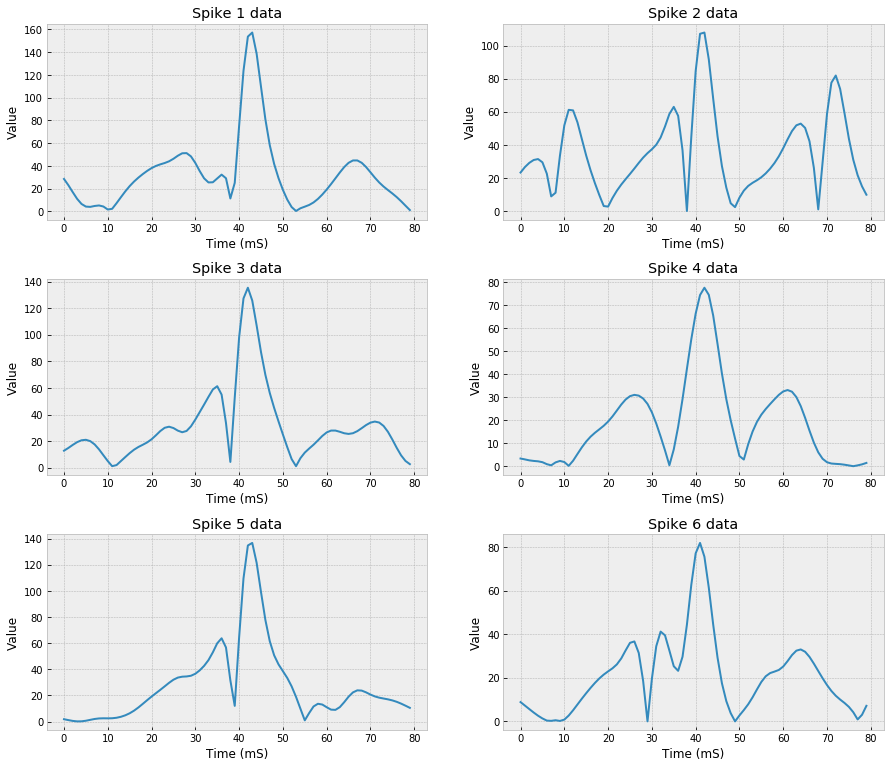

In [16]:
f = plt.figure(figsize=(15,13))
cut_spikes = spikes[18:24] # choosing "random" middle spikes

for i in range(1,6+1):
    t_spike = np.array(range(len(cut_spikes[i-1]))) # convert data to miliseconds
    ax = f.add_subplot(320 + i)
    ax.plot(t_spike, cut_spikes[i-1], label="Spike " + str(i) + " data")
    ax.set_xlabel("Time (mS)")
    ax.set_ylabel("Value")
    ax.set_title("Spike " + str(i) + " data")
    
f.subplots_adjust(wspace = 0.2, hspace=0.3) # gives the graphs extra spacing. I found this from https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots_adjust.html

plt.show()

In this step, we detected spikes and separated the data we wanted into separate arrays. There were a few issues here, however: 
1. Since the data was not sampled continuously, it may not meet the threshold, so I had to record whenever the data was equal to or over the threshold. However that means that multiple points could have been recorded on the same spike train, and we did not want to duplicate data.
2. To combat (1) I put in a boundary between the spikes we would record. I wanted to take 2mS of data around each spike, so for each index where the data was above the threshold, I would only record the spike train data if the index was not within the indices equivalent of 1mS.
3. While this did reduce the number of detected spikes from 237 to 38, some of those eliminated could have been actually different spikes. 
4. The advantage of this "manual" spike detection was that I could easily find the maximum of each spike and line them up. However, with my buffer, I could no longer do this and so the maximums may be at slightly different places.

Having said that, the spikes did come out pretty well, and each does look like a fairly nice spike.

## Dimensionality reduction <a id="reduction">
    
Next, we must convert our many-dimensional data into just a few that we can both visualize and cluster.

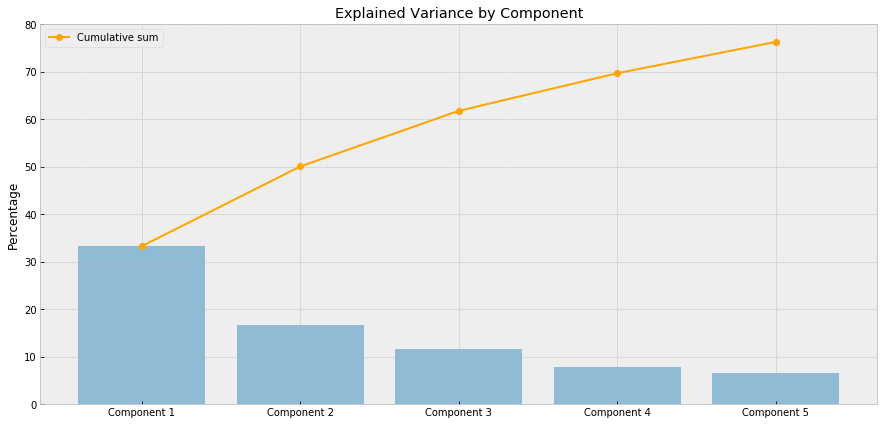

In [17]:
numComponents = 5
pca = PCA(n_components = numComponents).fit(np.array(spikes))


# Graphing help from https://python-graph-gallery.com/connected-scatter-plot/, https://plot.ly/ipython-notebooks/principal-component-analysis/, https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
plt.figure(figsize=(15,7))
objects = ["Component " + str(i+1) for i in range(numComponents)]
y_pos = np.arange(len(objects))
performance = pca.explained_variance_ratio_ * 100
cumsum = np.cumsum(performance)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title("Explained Variance by Component")
plt.ylabel("Percentage")
plt.plot(y_pos,cumsum, linestyle='-', marker='o', c = "orange", label="Cumulative sum")
plt.legend(loc="best")
plt.show()

As you can see above, the first two to three components are *pretty good* at capturing the variance of the data – the purpose of Principal Components Analysis – but not *great*. Ideally, the first two alone would capture more than 80 percent of the data, but we need 5 to be able to capture that. 

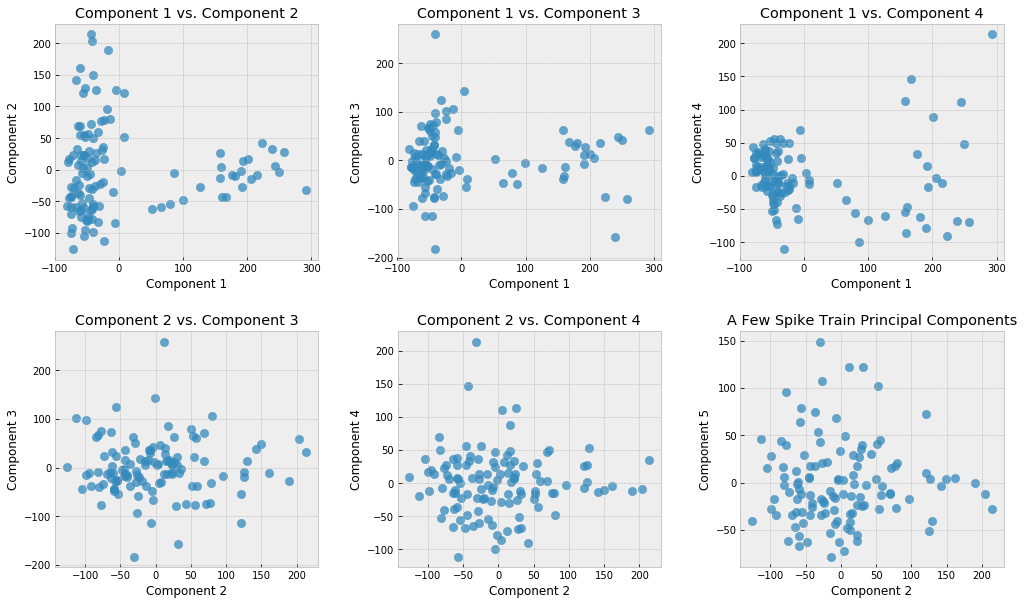

In [18]:
numComponents = 5
pca = PCA(n_components = numComponents)
x_pca = pca.fit(np.array(spikes)).transform(np.array(spikes))
f = plt.figure(figsize=(17,10))
reduced_data = np.array([x_pca[:,i] for i in range(numComponents)])
for i in range(3):
    ax = f.add_subplot(231 + i)
    ax.scatter(reduced_data[0],reduced_data[i+1], s=70, alpha=0.75, marker = "o")
    ax.set_xlabel("Component " + str(1))
    ax.set_ylabel("Component " + str(i+2))
    ax.set_title("Component " + str(1) + " vs. Component " + str(i+2))
    ax.axis("tight")
for i in range(1,4):
    ax = f.add_subplot(230 + 3 + i)
    ax.scatter(reduced_data[1],reduced_data[i+1], s=70, alpha=0.75, marker = "o")
    ax.set_xlabel("Component " + str(2))
    ax.set_ylabel("Component " + str(i+2))
    ax.set_title("Component " + str(2) + " vs. Component " + str(i+2))
#     ax.axis("tight")

f.subplots_adjust(wspace = 0.3, hspace=0.3)
plt.title("A Few Spike Train Principal Components")
plt.show()

# Now x_pca is a two-dimensional list of the two axes along the data with the most variance

Above you can see a few of the principal components plotted against each other. Clearly, component 1 vs. component 2 has the most separated graph – but that comes at no surprise, since that is the purpose of PCAs. Still, they do not separate extremely well. Especially in the bottom three graphs, there is a lot of overlap and just general confusion. 

The purpose of this step was to reduce the dimensionality of our spike train data, and that is what we successfully did. Each spike train that we had before was comprised of about 80 datapoints, which means our data had been 80-dimensional. Now we've separated it into the main 5 dimensions, and we will not even use all of them! Technology is remarkable. In terms of method, **PCAs are not the most accurate way of reducing the dimensionality of waveforms**. They can take apart the physical data, like the height of the wave, how wide it is, the number of smaller waves around it, but they is not as good at taking into account shape. Also, **they select for the axes for greatest variance – which are not necessarily the ones that best separate the data (what we want)**. 

The method much better at this involves [wavelets](http://mathworld.wolfram.com/Wavelet.html), but those are extremely complicated and hard to understand. They essentially pass a filter over the data that converts the shape of waveforms into some sort of measurable quantity, but the exact method for doing so is abstract.

The greatest takeaway from this step is that the data is still extremely noisy, even after all our work to clean it up. Perhaps that is the area of this analysis that needs the most improvement.

## Clustering <a id="clustering">

Our final step is to cluster this "separated" data into distinct groups. There are many, many different classifiers in existence, some much more robust and accurate than others, but for our fairly rudimentary knowledge we will use a more basic one called DBSCAN.

In [19]:
# These are functions I wrote myself for a Compsci 630 project in the fall. They are explained below.
def stD(df,a,b):
    '''Returns the distance between the points corresponding to the a-th and b-th samples of the dataframe'''
    # Calculates distance, assumes the two numerical columns are the first two columns in the dataset
    total = 0
    for i in range(2):
        total += (df.iloc[a,i] - df.iloc[b, i])**2
    return math.sqrt(total)

def pointsWithinDistanceEpsilon(df,i, eps, numPoints):
    '''Determines the number of points within a given distance epsilon (defined above) of the i-th sample of the dataframe.
       Returns an array with the indices of these points'''
    points = []
    for j in range(df.shape[0]):
        d = stD(df,i,j)
        if d <= eps and d > 0: # makes sure it is not the same point
            points.append(j)
    return points

def dbscan(df, eps, numPoints):
    '''Returns a series corresponding to the cluster of each sample in the dataframe'''
    clusters = [-1] * df.shape[0] # makes an array of -1's that has the same length as the number of samples in the dataframe
    currentCluster = 1
    
    while -1 in clusters: # while there is a point that has not been assigned a cluster yet
        point = clusters.index(-1) # the first point in the list without an assigned cluster
        clusters[point] = currentCluster
        corePointsLeft = [point] # list of all core points
        while len(corePointsLeft) > 0:
            arr = pointsWithinDistanceEpsilon(df,corePointsLeft[0], eps, numPoints) # the number of points around the next core point in line
            for elem in arr:
                if (clusters[elem] == -1 # checks to make sure the element has not been assigned a cluster
                                         # otherwise this will go into infinite recursion
                    and len(pointsWithinDistanceEpsilon(df,elem, eps, numPoints)) >= numPoints):
                    corePointsLeft.append(elem) # then it is a core point and will be checked later
                clusters[elem] = currentCluster
            corePointsLeft.pop(0) # now that the core point has been "exhausted", it is removed from the array
        
        currentCluster += 1 # after all the nearby points have been clustered, it switches to a new cluster and starts again
                
    return pd.Series(clusters)


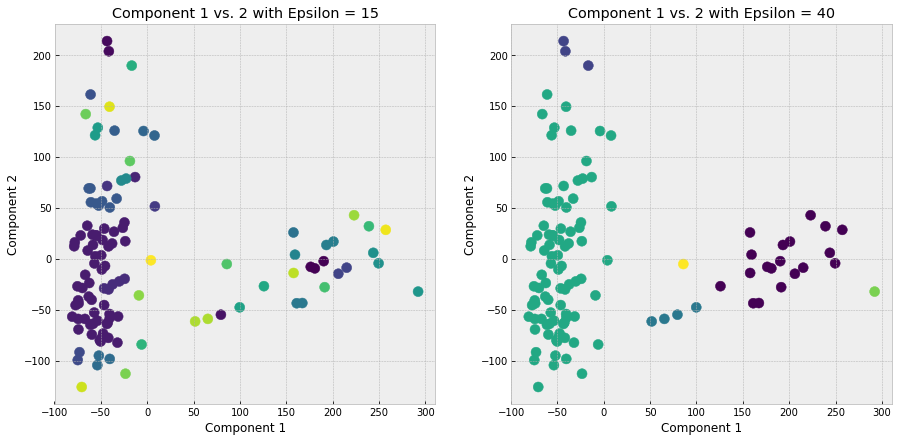

In [20]:
df = pd.DataFrame(data = reduced_data.transpose())

epsilon1 = 15
numPoints1 = 4

clusters1 = dbscan(df, epsilon1, numPoints1)

f = plt.figure(figsize=(15,7))
ax1 = f.add_subplot(121)
ax1.scatter(reduced_data[0],reduced_data[1], c = clusters1, s=100)
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax1.set_title("Component 1 vs. 2 with Epsilon = " + str(epsilon1))

ax2 = f.add_subplot(122)

epsilon2 = 40
numPoints2 = 4
clusters2 = dbscan(df, epsilon2, numPoints2)
ax2.scatter(reduced_data[0],reduced_data[1], c = clusters2, s=100)
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_title("Component 1 vs. 2 with Epsilon = " + str(epsilon2))
plt.show()

In this section, we used a clustering known as DBSCAN, which stands for [density-based spatial clustering of applications with noise](https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80). It is an unsupervised clustering algorithm, which means that it starts with zero knowledge about what the clusters are supposed to look like, and tries to match points with the others that are closest to them. This function is importable directly, but for CSC630 this fall one of our assignments was to code it on our own, so with a few changes, I could implement it myself. I personally find my own code to be much easier to understand and tweak to my needs than any built-in function – plus I was getting a bunch of formatting erros when I tried to use the built-in one.

**How it works:** `dbscan()` takes in the data as a pandas dataframe (which is just a table – in our case the columns are the first five PCAs we found above) and goes point by point to try and find all the points next to it. There are two arguments this function takes in, *epsilon* and *numPoints*, which refer to the spacing radius between points and the minimum number of points to form a close group (this does not apply to outliers). It takes a first point, sees how many points are with radius *epsilon* of it, and converts them to the same group, then performs the same operation on those points to try and snag other ones. Eventually, the points will be clustered into a finite number distinct groups.

The fruits of this task are immediately evident. The points split up fairly well and we can see a few different groups begin to appear. These are what we now believe to correspond to individual neurons, and if we were using an online validation checker, we would submit those groupings to determine our score. 

**... And that's it!**

## Conclusion and Issues <a id = "conclusion">

While we are done, there are many things that need improvement and necessitate future attention. Some have been shared above, but a host of other ones exist. Here are just a few.
1. First, we used one random electrode from the entire dataset, so the comments I made about accuracy may not exactly line up with the graphs you are seeing. The electrode we're using could be damaged, could be touching another, or have a host of other issues that we will not see by looking only at its dataset. Also, we are only using 40,000 datapoints (2s of data), rather than the entire 4,800,000 – another huge source of lost information.

2. Second, the filtfilt method is not entirely noncausal. The result of this is that the spikes look symmetrical, but that is not their true form. Yes, we are held back by the capped sampling frequency, but they still have been distorted.

3. Third, we did not line up the maximums of the spikes. As a result, we may have cut out some key information from some spikes that may have created the outliers. Also, by not using wavelets, we lost a lot of information about their shapes. 

4. Fourth, we only visualized the first few PCAs. In this respect we are held back by the limiting nature of human senses – we tend to feel uncomfortable with things we cannot visualize. We first used PCAs to reduce the dimensions down to two (technically five, but again we could not visualize all at once), and then we used the clustering algorithm to find clusters in the first two dimensions. 

But we're not quite done. These were just the issues in my method itself. As for the field of Spike Sorting as a whole:

* Electrodes can drift during recording, misleading our data.
* Neurons do not fire in the same way each time. Neuron [bursting](http://www.scholarpedia.org/article/Bursting) can occur, which is when a neuron starts firing extremely rapidly for no good reason.
* Spikes can overlap, especially if the 1mS buffer we placed was not enough.
And most importantly... *we will never know what is right!* Unlike most machine learning algorithms or BCI modeling, we can't try out a model, see if it works, and then change it based on the results. If our spike sorting is wrong, there's no way we can tell, and all future computation will be based on flawed information. So we must just work with training data (which is either synthesized or verified by an existing algorithm), which is far from the real thing. And this isn't just some advertizing algorithm – if spikes are sorted incorrectly, *people may die*.

This field almost raises more questions than it answers. But at least now we've had a look into the behind the scenes of computation and neuroscience. And as you can see, nearly all of these issues involve loss of information. It is quite remarkable that a simple recording of neuron spikes can have so much data embedded within, and this is the preliminary step of modeling the brain! **The brain is truly remarkable.**

----
## Sources

**Notes on method:** In this project I began learning about this topic by simply reading about it. I consulted a huge number of sources, took notes on what they felt were the most important parts of spike sorting and instructions on how to perform it, and then found a dataset and performed it myself. I would love to have been able to do in-text citations, but since the ideas I shared were less so author's opinions and more so knowledge about the source, I wasn't sure how to cite them. Nearly all of the of the comments I shared along the way were my own thoughts on the particular dataset I used – albeit with the help of prior knowledge from these sources – and whenever I got an idea directly from one single source, I cited it, either in a code comment or a markdown link. I really hope that is alright since I have taken extreme care to not regurgitate the information I have been taking in – actually the reason I thought of doing an iPython notebook in the first place.

*Information*

* Brain. Photograph. fronteirs in Neuroscience. Accessed May 29, 2019. https://www.frontiersin.org/ 
     journals/neuroscience. 
 
* Da Goh, Clinton Zheng. Spike Sorting. Accessed May 29, 2019. https://pdfs.semanticscholar.org/c440/ 
     87f5007d395f7219726620b67ddf2e835953.pdf. 
 
* de Prado, Kelvin Salton. "How DBSCAN works and why should we use it?" Towards Data Science (blog). 
     Entry posted April 1, 2017. Accessed May 29, 2019. https://towardsdatascience.com/ 
     how-dbscan-works-and-why-should-i-use-it-443b4a191c80. 
 
* Quiroga, Quian. "Spike Sorting." Current Biology, R45-R46. Accessed May 29, 2019. 
     https://www.cell.com/current-biology/pdf/S0960-9822(11)01254-1.pdf. 
 
* Quiroga, Rodrigo Quian. "Spike Sorting." Scholarpedia. Last modified 2007. Accessed May 29, 2019. 
     http://www.scholarpedia.org/article/Spike_sorting. 
 
* Quiroga, RQ, Z. Nazdazy, and Y. Ben-Shaul. Unsupervised spike detection and sorting with wavelets 
     and superparamagnetic clustering. August 2004. Accessed May 29, 2019. https://core.ac.uk/ 
     download/pdf/4881054.pdf. 
 
* Rey, Hernan Gonzalo, and Carlos Pedriera. Past, present and future of spike sorting techniques. 
     Research report no. 119B. October 2017. Accessed May 29, 2019. https://www.sciencedirect.com/ 
     science/article/pii/S0361923015000684. 
 
* "scipy.signal.filtfilt." SciPy.org. Accessed May 29, 2019. https://docs.scipy.org/doc/scipy-0.14.0/ 
     reference/generated/scipy.signal.filtfilt.html. 
 
* Spike Sorting. Accessed May 29, 2019. https://neurophysics.ucsd.edu/publications/obd_ch3_2.pdf. 
 
* Weisstein, Eric W. "Wavelet." Wolfram Mathworld. Accessed May 29, 2019. http://mathworld.wolfram.com/ 
     Wavelet.html. 


*Data*
* http://www.spikesortingtest.com/datasets/

**NOTE:** As of today, 5/28/19, this website no longer works! It is unbelievable that I managed to secure this data and the instructions for using it in time, but I cannot cite it properly now, however.

*Image*
* Brain. Photograph. fronteirs in Neuroscience. Accessed May 29, 2019. 
     https://www.frontiersin.org/journals/neuroscience. 